In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

### Load data

Load dataset prepared using basic transfromation of signals. 

In [3]:
df = pd.read_csv("./../data/prepared/prepared_basic.csv", index_col="identifier")
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 6173 entries, 0.0 to 60911.0
Columns: 169 entries, Max_freq_First_EEG to target
dtypes: float64(168), int64(1)
memory usage: 8.0 MB


In [4]:
df.head()

,Max_freq_First_EEG,Sum_freq_First_EEG,Mean_freq_First_EEG,Var_freq_First_EEG,Peak_freq_First_EEG,Skew_freq_First_EEG,Kurtosis_freq_First_EEG,mean_First_EEG,min_First_EEG,max_First_EEG,...,Rms_Z_axis,Power_Z_axis,Peak_Z_axis,PTP_Z_axis,CrestFactor_Z_axis,Skew_Z_axis,Kurtosis_Z_axis,FormFactor_Z_axis,PulseIndiicator_Z_axis,target
identifier,,,,,,,,,,,,,,,,,,,,,
0.0,4.897655e+06,7.435633e+07,9914.177999,1.493854e+10,4.897655e+06,24.652159,799.455877,-2.231333,-482.286896,642.120239,...,0.005207,0.000027,0.016703,0.029954,3.207928,0.662471,1.400366,75.092132,240.890145,0
1.0,2.327903e+06,5.202239e+07,6936.318869,5.205112e+09,2.327903e+06,17.679821,405.649139,0.971973,-344.952515,418.611664,...,0.030240,0.000914,0.121454,0.186319,4.016346,1.529461,5.441694,-141.701947,-569.124086,0
2.0,1.152274e+06,4.648923e+07,6198.563657,2.830893e+09,1.152274e+06,12.903734,200.402913,0.009201,-272.113434,835.612976,...,0.008449,0.000071,0.038747,0.056668,4.585957,1.237417,5.403179,37.821384,173.447231,0
3.0,1.949074e+06,5.940327e+07,7920.435792,6.248728e+09,1.949074e+06,16.556910,315.882635,-0.060141,-363.219391,302.055908,...,0.084393,0.007122,0.223697,0.422125,2.650647,-0.456333,0.276363,-57.398587,-152.143402,0
4.0,7.260203e+07,1.427667e+09,190355.567491,5.501804e+12,7.260203e+07,19.725836,465.537184,0.313686,-1949.282471,2986.843018,...,0.052034,0.002708,0.183920,0.297231,3.534590,-1.039427,2.997090,34.708235,122.679384,0


### Prepare data for modelling

Isolate a test set for future final model. 

In [5]:
# define features and target
y = df.target
X = df.drop("target", axis=1)

# separate train and test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=456)

Now values will be scaled using standard scaler:

In [6]:
# define scaler
scaler = StandardScaler(with_std=True)

# scale train and test sets
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [7]:
X_train_scaled.head()

,Max_freq_First_EEG,Sum_freq_First_EEG,Mean_freq_First_EEG,Var_freq_First_EEG,Peak_freq_First_EEG,Skew_freq_First_EEG,Kurtosis_freq_First_EEG,mean_First_EEG,min_First_EEG,max_First_EEG,...,var_Z_axis,Rms_Z_axis,Power_Z_axis,Peak_Z_axis,PTP_Z_axis,CrestFactor_Z_axis,Skew_Z_axis,Kurtosis_Z_axis,FormFactor_Z_axis,PulseIndiicator_Z_axis
0,-0.034482,-0.035511,-0.035511,-0.022873,-0.034482,0.000189,-0.265600,-0.019077,0.051495,-0.055258,...,-0.148374,-0.286391,-0.148348,-0.270990,-0.274427,-0.304337,-0.968674,-0.418411,-0.033730,-0.036670
1,-0.034486,-0.035512,-0.035512,-0.022873,-0.034486,-0.762257,-0.697739,0.005142,0.055868,-0.058924,...,-0.146336,-0.197569,-0.146316,-0.211133,-0.222454,-0.040378,0.937786,-0.293352,-0.053153,-0.059665
2,-0.034485,-0.035512,-0.035512,-0.022873,-0.034485,0.396197,0.243951,0.012576,0.055301,-0.058475,...,-0.148196,-0.272402,-0.148169,-0.266015,-0.264437,-0.601481,-0.299304,-0.414406,-0.010922,-0.014236
3,-0.034486,-0.035512,-0.035512,-0.022873,-0.034486,-0.621065,-0.644790,-0.006494,0.055679,-0.058537,...,-0.142619,-0.115789,-0.142572,-0.148428,-0.153338,0.181476,0.518129,-0.127517,-0.026084,-0.030163
4,-0.034486,-0.035512,-0.035512,-0.022873,-0.034486,-0.353796,-0.287183,0.001625,0.056109,-0.058910,...,-0.147455,-0.235069,-0.147432,-0.243729,-0.249591,-0.476840,0.739472,-0.455755,-0.224609,-0.218614


### PCA on each subcategory

Now, the goal is to apply PCA to each categpory 

In [8]:
# define category
category = {
    "First_EEG": (1, 7501, 250), 
    "Second_EEG": (7501, 15001, 250), 
    "Third_EEG": (15001, 22501, 250), 
    "Fourth_EEG": (22501, 30001, 250), 
    "Fifth_EEG": (30001, 37501, 250), 
    "X_axis": (37501, 39001, 50), 
    "Y_axis": (39001, 40501, 50), 
    "Z_axis": (40501, 42001, 50) 
}

In [9]:
# prepare PCA
n_comp = 8
PCA_per_category = {key: PCA(n_components=n_comp) for key in category.keys()}
train_dataframes = []
test_dataframes = []
variance_ratio = {}

for key, pca in PCA_per_category.items():
    col_cat = [col for col in X_train_scaled if key in col]
    X_cat_train = X_train_scaled[col_cat]
    X_cat_test = X_test_scaled[col_cat]

    X_cat_train_pca = pca.fit_transform(X_cat_train)
    X_cat_test_pca = pca.transform(X_cat_test)

    # transform into dataframe
    columns = [f"PC{i+1}_" + key for i in range(n_comp)]
    X_cat_train_pca = pd.DataFrame(data=X_cat_train_pca, columns=columns)
    X_cat_test_pca = pd.DataFrame(data=X_cat_test_pca, columns=columns)

    train_dataframes.append(X_cat_train_pca)
    test_dataframes.append(X_cat_test_pca)

    # Get explained variance ratio
    variance_ratio[key] = np.cumsum(pca.explained_variance_ratio_)

In [10]:
X_train_pca = pd.concat(train_dataframes, axis=1)
X_test_pca = pd.concat(test_dataframes, axis=1)

In [11]:
X_train_pca.head()

,PC1_First_EEG,PC2_First_EEG,PC3_First_EEG,PC4_First_EEG,PC5_First_EEG,PC6_First_EEG,PC7_First_EEG,PC8_First_EEG,PC1_Second_EEG,PC2_Second_EEG,...,PC7_Y_axis,PC8_Y_axis,PC1_Z_axis,PC2_Z_axis,PC3_Z_axis,PC4_Z_axis,PC5_Z_axis,PC6_Z_axis,PC7_Z_axis,PC8_Z_axis
0,-0.150877,0.037350,-0.007535,-0.196188,0.002084,-0.069064,-0.067898,-0.025034,-0.155442,-0.067549,...,-0.139054,0.066782,-1.007558,1.325004,-0.017092,-0.185793,-1.003692,0.307749,0.558632,-0.032831
1,-0.145712,0.397938,0.040181,-0.955734,-0.033457,-0.114857,-0.124686,-0.011585,-0.103413,1.358216,...,-0.508179,-0.219195,-0.526796,-0.502025,-0.079240,0.141162,1.052278,-0.348170,-0.508631,-0.080104
2,-0.177913,-0.560894,-0.017967,0.213555,-0.011478,-0.030643,-0.183411,0.032818,-0.179845,-0.546443,...,0.024068,-0.026915,-0.685713,-0.177671,-0.014895,-0.577356,0.709552,0.652135,-0.473790,0.128641
3,-0.150104,0.191066,0.042441,-0.900927,-0.020383,-0.127112,-0.244948,0.029846,-0.148651,0.180999,...,-0.636993,-0.031271,-0.578347,0.401251,-0.024529,0.343043,-0.228350,-0.756843,0.114712,-0.143414
4,-0.162550,-0.152729,0.030060,-0.583452,-0.018364,-0.099837,-0.271757,0.061340,-0.152773,0.005906,...,0.722120,0.052967,-0.994023,1.375866,-0.258913,0.883789,-0.266259,-0.692870,0.070066,-0.018970


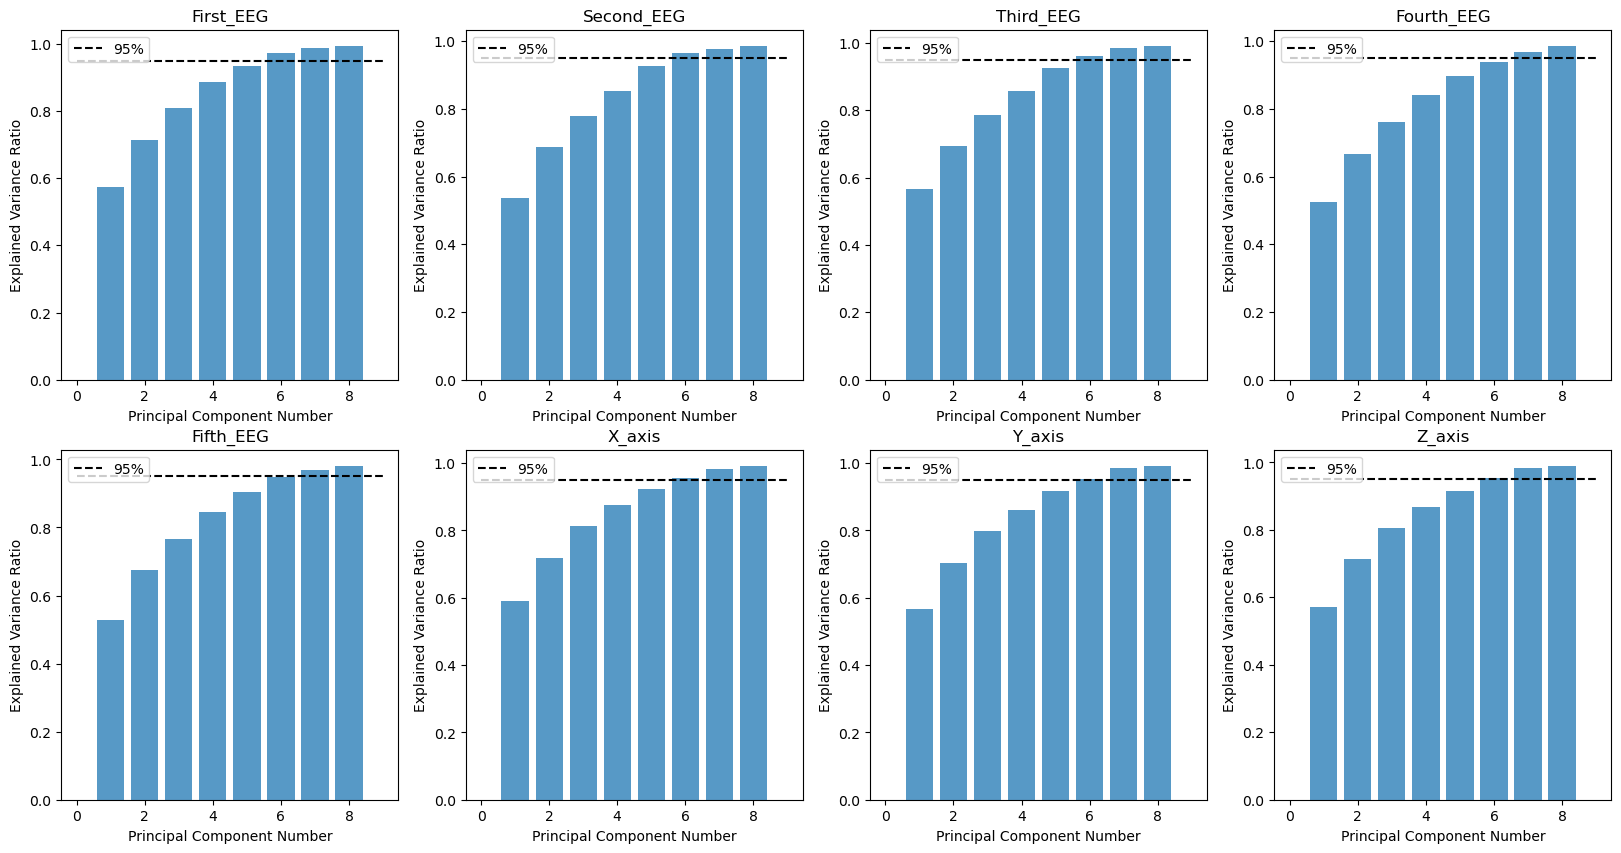

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

i = 0
for key, var in variance_ratio.items():
    ax[i//4, i%4].bar(range(1, len(var) + 1), var, alpha=0.75)  #, ax=ax[i//4, i%4])
    ax[i//4, i%4].hlines(y=0.95, xmin=0., xmax=9., colors="black", linestyles='dashed', label="95%")
    # plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', label='Cumulative Explained Variance')
    ax[i//4, i%4].set_xlabel('Principal Component Number')
    ax[i//4, i%4].set_ylabel('Explained Variance Ratio')
    ax[i//4, i%4].set_title(key)
    ax[i//4, i%4].legend()

    i += 1 

plt.show()

### PCA on the whole dataset

In [13]:
# define parameters of the algo
n_components = 38
pca_all = PCA(n_components=n_components)

In [14]:
X_train_pca_all = pca_all.fit_transform(X_train_scaled)
X_test_pca_all = pca_all.transform(X_test_scaled)

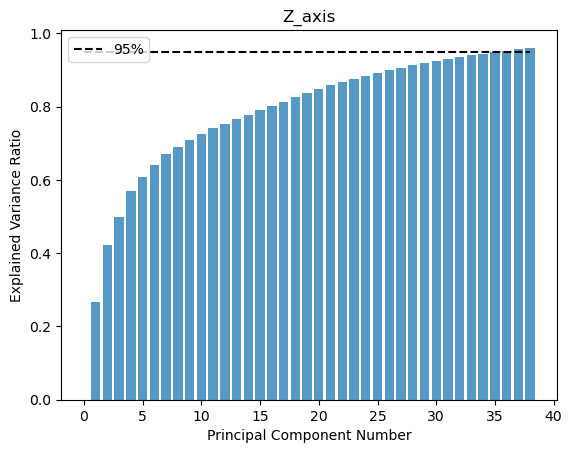

In [15]:
var = np.cumsum(pca_all.explained_variance_ratio_)

plt.bar(range(1, len(var) + 1), var, alpha=0.75)  
plt.hlines(y=0.95, xmin=0., xmax=n_components, colors="black", linestyles='dashed', label="95%")
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title(key)
plt.legend()

### POC of a model without PCA:

POC of a model based on features selected by xgboost.

In [16]:
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=len(set(y)),  # Number of classes
    random_state=42
)
cross_val_score(xgb_classifier, 
                X_train_scaled, 
                y_train, 
                cv=3, scoring='f1_macro')

array([0.65607111, 0.63931557, 0.65059768])

In [17]:
baseline = xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=len(set(y)),  # Number of classes
    random_state=42
)

baseline.fit(X_train_scaled, y_train)
y_pred = baseline.predict(X_test_scaled)

In [27]:
f1 = f1_score(y_pred, y_test, average='macro')
accuracy = accuracy_score(y_pred, y_test)

print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

F1-score: 0.6661317267490411
Accuracy: 0.8170040485829959


### POC of a model using PCA on each categroy of signals

In [19]:
model_pca = RandomForestClassifier()
# cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='f1_macro')
model_pca.fit(X_train_pca, y_train)

RandomForestClassifier()

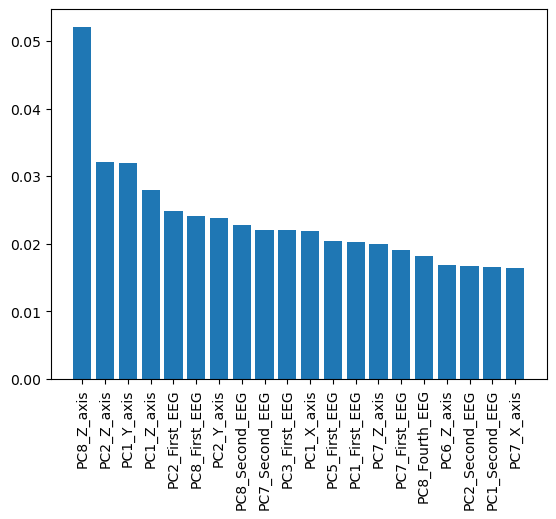

In [20]:
# Extract coefficients and identify important features
coefficients = model_pca.feature_importances_
selected_features = pd.DataFrame(coefficients, columns=['Importance'])
selected_features['features'] = X_train_pca.columns

# Display selected features
plot = selected_features.sort_values(by="Importance", ascending=False).iloc[:20]
plt.bar(list(plot.features), list(plot.Importance))
plt.xticks(rotation=90)
plt.show()

In [22]:
xgb_classifier_pca = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=len(set(y)),  # Number of classes
    random_state=42
)
cross_val_score(xgb_classifier_pca, 
                X_train_pca, 
                y_train, 
                cv=3, scoring='f1_macro')

array([0.53658484, 0.5471056 , 0.5518723 ])

Obviously, results are worse than the baseline. In fact, each feature in the baseline has a little importance. Applying PCA to each signal and oosing 5% of the information on each signal may be sufficient to lose so much information. 

### PCA on all features

In [23]:
xgb_classifier_pca_all = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=len(set(y)),  # Number of classes
    random_state=42
)
cross_val_score(xgb_classifier_pca_all, 
                X_train_pca_all, 
                y_train, 
                cv=3, scoring='f1_macro')

array([0.49068409, 0.47026474, 0.49294966])

Again, results are worse. As a conclusion, as PCA treats only high variance without taking into account the target, the algo may not be suitable for the rest. Thus, PCA might not be used for the rest of the experience. 

### General conclusion

A POC has been designed. Two main points have to be kept in mind for the rest of the study. 

Firstly, PCA is not a good solution for feature dimension space reduction. As it doesn't take into account the response variable, it gives poor results in our problem. 

Secondly, all our experiments for feature selection or feature space dimension reduction have given worse results. We might consider deep learning to extract information from our large set of features. 